# Imports

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('daily_prices/AAPL.csv')[['Open', 'High', 'Low', 'Volume', 'Close']] 
df.head()

,Open,High,Low,Volume,Close
0,55.105000,55.720001,54.209999,161351600,55.527500
1,55.290001,55.457500,54.317501,123164000,54.340000
2,54.732498,55.747501,54.189999,116736000,55.537498
3,55.575001,55.660000,54.834999,91541600,55.297501
4,54.465000,54.935001,53.250000,130325200,54.005001


In [3]:
# Extract the time and value columns
time_series = np.array(range(len(df['Date'])))  # Replace with your time column name
values = df['Close']                            # Replace with your value column name

# Stats Models Seasonal Decompose

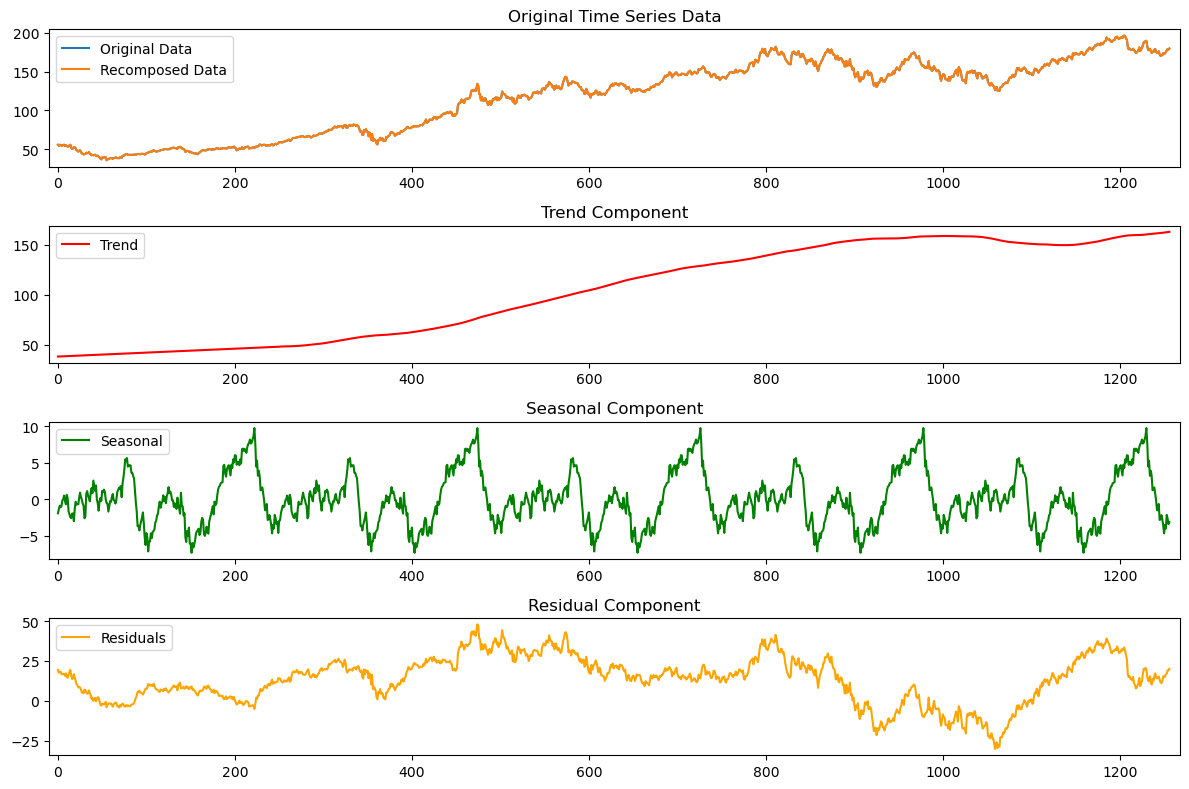

In [87]:
# Perform seasonal decomposition
result = sm.tsa.seasonal_decompose(values, model='additive', period=252, extrapolate_trend=25, two_sided=False)

# Plot the original data, trend, seasonal, and residuals
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(time_series, values, label='Original Data')
plt.plot(time_series, result.resid+result.trend+result.seasonal, label='Recomposed Data')
plt.xlim(-10,1268)
plt.legend()
plt.title('Original Time Series Data')

plt.subplot(4, 1, 2)
plt.plot(time_series, result.trend, label='Trend', color='red')
plt.xlim(-10,1268)
plt.legend()
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(time_series, result.seasonal, label='Seasonal', color='green')
plt.xlim(-10,1268)
plt.legend()
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(time_series, result.resid, label='Residuals', color='orange')
plt.xlim(-10,1268)
plt.legend()
plt.title('Residual Component')
plt.tight_layout()
plt.show()

# Plotting Seasonal Compnents (Extrapolating)

In [44]:
seasonal_forecast = result.seasonal[-252:].reset_index(drop=True).rolling(14, min_periods=1).mean()
seasonal_forecast

0     -4.581125
1     -3.748407
2     -3.445695
3     -3.058875
4     -2.713721
         ...   
247   -1.953549
248   -2.221897
249   -2.459955
250   -2.692216
251   -2.808813
Name: seasonal, Length: 252, dtype: float64

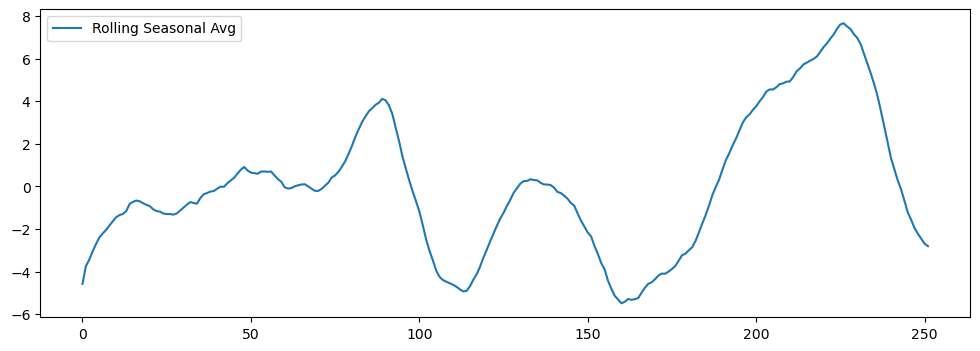

In [42]:
plt.figure(figsize=(12, 4))
plt.plot(result.seasonal[-252:].reset_index(drop=True).rolling(14, min_periods=1).mean(), label='Rolling Seasonal Avg')
plt.legend(loc='best')
plt.show()

# Plotting Trend Component (Extrapolating)

In [53]:
model = LinearRegression()
model.fit(time_series[-50:].reshape(-1, 1), result.trend[-50:])

trendline = model.intercept_ + model.coef_ * range(time_series[-1], time_series[-1]+365)

In [107]:
# read data
data = pd.read_csv('daily_prices/AAPL.csv')[['Open', 'High', 'Low', 'Volume', 'Close']] 

# detrend and deseason all columns
decomp, forecast = pd.DataFrame(), pd.DataFrame()
for col in data.columns:
    # detrend and deason column
    result = sm.tsa.seasonal_decompose(data[col], model='additive', period=252, extrapolate_trend=25, two_sided=False)
    
    # add decomposed column to dataframe
    decomp[col] = result.resid
    
    # create seasonal forecast component based on moving avg
    forecast['seasonal_forecast'] = result.seasonal[-252:].reset_index(drop=True).rolling(14, min_periods=1).mean()
    
    # create trend forecast component based on OLS
    model = LinearRegression()
    model.fit(np.array(data.index[-50:]).reshape(-1, 1), result.trend[-50:])
    forecast['trend_forecast'] = model.intercept_ + model.coef_ * range(data.index[-1], data.index[-1]+252)

# values for normalization
mins, maxs = decomp.min(), decomp.max()                           

# normalize input data
normalized = (decomp-mins)/(maxs-mins)

# remove outliers
for col in normalized.columns:
    z_scores = np.abs(stats.zscore(normalized[col]))
    outliers = z_scores > 3
    normalized[col][outliers] = normalized[col].mean()

normalized

,Open,High,Low,Volume,Close
0,0.591659,0.588529,0.633835,0.226808,0.634482
1,0.605714,0.594079,0.629607,0.176695,0.611604
2,0.582608,0.581486,0.626782,0.148861,0.620272
3,0.595912,0.581615,0.630637,0.102271,0.619432
4,0.585176,0.572400,0.604981,0.196153,0.600133
...,...,...,...,...,...
1252,0.562846,0.558800,0.601417,0.253179,0.599222
1253,0.563796,0.574004,0.597586,0.292820,0.606740
1254,0.584767,0.584155,0.624264,0.245361,0.630452
1255,0.599686,0.599241,0.646588,0.289955,0.630979


# Test dataset

In [3]:
from dataset import SP_500
from torch.utils.data import DataLoader

dataset = SP_500('daily_prices')
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=0)

c:\Users\zapul\anaconda3\envs\ds\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
example = next(iter(dataloader))[0]
example

tensor([[ 0.0010, -0.0054, -0.0219,  0.0360, -0.0324],
        [-0.0222, -0.0187, -0.0081, -0.0242, -0.0007],
        [-0.0064, -0.0016,  0.0009,  0.0239,  0.0032],
        ...,
        [-0.0156,  0.0030, -0.0030, -0.0324, -0.0113],
        [ 0.0007, -0.0109, -0.0095,  0.0078,  0.0065],
        [ 0.0016,  0.0110,  0.0226, -0.0038,  0.0140]], dtype=torch.float64)

# Create trend and seasonal forecasts

In [ ]:
# create seasonal forecast component based on moving avg
forecast['seasonal_forecast'] = result.seasonal[-252:].reset_index(drop=True).rolling(14, min_periods=1).mean()

# create trend forecast component based on OLS
model = LinearRegression()
model.fit(np.array(data.index[-50:]).reshape(-1, 1), result.trend[-50:])
forecast['trend_forecast'] = model.intercept_ + model.coef_ * range(data.index[-1], data.index[-1]+252)